In [ ]:
# LinkNet with ResNet34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [ ]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
d = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  d + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs   = getData(dataPath, trainImgsFile)
trainLabels = getData(dataPath, trainLabelsFile)

valImgs    = getData(dataPath, valImgsFile)
valLabels  = getData(dataPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)


Got train and validation data
(1000, 480, 480, 1) (251, 480, 480, 1)
(1000, 480, 480, 1) (251, 480, 480, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.PSPNet('vgg19', input_shape=(480, 480, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [6]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [7]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [8]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [9]:
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 120s 120ms/sample - loss: 0.3128 - accuracy: 0.9564 - updated_mean_io_u: 0.0801 - val_loss: 0.1830 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 2/30
1000/1000 [==============================] - 87s 87ms/sample - loss: 0.1062 - accuracy: 0.9761 - updated_mean_io_u: 0.0905 - val_loss: 0.1516 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 3/30
1000/1000 [==============================] - 87s 87ms/sample - loss: 0.0959 - accuracy: 0.9767 - updated_mean_io_u: 0.1007 - val_loss: 0.1578 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 4/30
1000/1000 [==============================] - 87s 87ms/sample - loss: 0.0885 - accuracy: 0.9773 - updated_mean_io_u: 0.1068 - val_loss: 0.1629 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0813
Epoch 5/30
1000/1000 [==============================] - 87s 87ms/sample - loss: 0.0834 - accuracy: 0.9780 - updated_mea

dict_keys(['loss', 'accuracy', 'updated_mean_io_u', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u'])


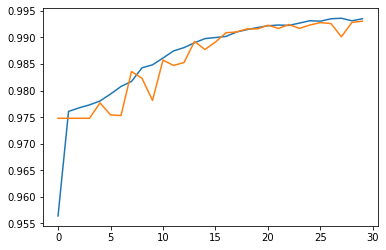

In [10]:
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

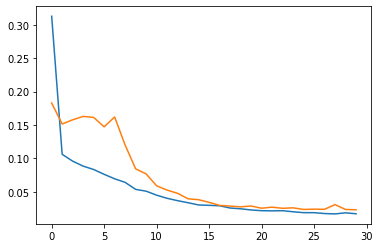

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

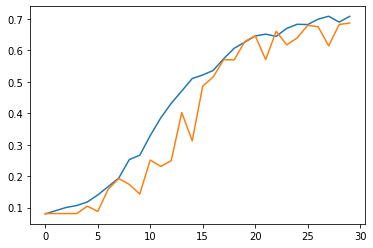

In [12]:
plt.plot(history.history['updated_mean_io_u'])
plt.plot(history.history['val_updated_mean_io_u'])

In [13]:
# get the testdata
testImgs   = getData(dataPath, testImgsFile)
testLabels = getData(dataPath, testLabelsFile)
print(testImgs.shape, testLabels.shape)

(617, 480, 480, 1) (617, 480, 480, 1)


In [19]:
trainImgs = None
trainLabels = None
valImgs = None
valLabels = None

In [18]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 28s 45ms/sample - loss: 0.0197 - accuracy: 0.9932 - updated_mean_io_u: 0.6937


[0.019729113719475905, 0.9931582, 0.69374895]

In [16]:
# save the model weights
weightFileName = "PSPVggNet19_30e_16b_NEW.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
model.save_weights(weightPath + "/" + weightFileName)


In [ ]:
model.load_weights(weightPath + "/" + weightFileName)
#model.evaluate(testImgs, testLabels)

In [ ]:
modelFileName = "PSPVggNet19_30e_16b_NEW"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET'
model.save(modelPath + "/" + modelFileName)

In [19]:
# Check the GPU configuration
!nvidia-smi

Thu May 27 22:02:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |  10850MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
y_preds = model.predict(testImgs)
y_preds = (y_preds >= 0.5).astype(np.uint8)

In [ ]:
y_preds = ((model.predict(testImgs)) >= 0.5).astype(np.uint8)

In [ ]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

In [ ]:
yPreds = tf.argmax(ypreds, axis=-1)
yPreds = yPreds.numpy()

In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(yPreds[i])
plt.show()

print(np.unique(yPreds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()